In [43]:
import torch

def get_infinite_data(data_loader, n, init_step :int = None, yield_step = True):
    step = 0 if init_step is None else init_step
    while True:
        for batch in data_loader:
            step = step + 1
            if n >= 0 and step > n:
                return
            if yield_step:
                yield step , batch
            else:
                yield batch


class InfiniteDataLoader:
    def __init__(self, dataloader, step, init_step = None, yield_step = True, *args, **kwargs) -> None:
        init_step = 0 if init_step is None else init_step
        self.len = None if step < 0 else (step - init_step) 
        self.dataloader = get_infinite_data(dataloader, step, init_step, yield_step)
        
    def __len__(self):
        return max(self.len, 0)
    
    def __iter__(self):
        return self

    def __next__(self):
        return next(self.dataloader)
    

class ParallelInfiniteDataLoader:
    def __init__(self, *dataloaders, step = 20000, init_step = None, yield_step = True, yield_domain = True) -> None:
        self.yield_dmain = yield_domain
        self.yield_step = yield_step
        init_step = 0 if init_step is None else init_step
        self.init_step = init_step
        self.len = None if step < 0 else (step - init_step) 
        self.dataloaders = [get_infinite_data(dataloader, step, init_step, yield_step) for dataloader in dataloaders]
        
    def __len__(self):
        return max(self.len, 0)
    
    def __iter__(self):
        return self

    # def __next__(self):
    #     result = [next(dataloader) for dataloader in self.dataloaders]
    #     step = result[0][0]
    #     result = [ele for _, ele in result] ##[N,B,data]
    #     return step, *result

    def __next__(self):
        if self.yield_step:
            result = [next(dataloader) for dataloader in self.dataloaders]
            step = result[0][0]
            if self.yield_dmain:
                B = [res_[1][0].shape[0] for res_ in result]
                result = [(*ele,torch.tensor([enum] * B[enum])) for enum, (_, ele) in enumerate(result)] ##[N,data_size, B]
            else:
                result = [ele for (_, ele) in result] ##[N,data_size, B]
            result = list(zip(*result)) ##[data_size, N,B]
            result = tuple(torch.cat(data_ele, dim= 0) for data_ele in result) ##[data_size, N*B]
            return step, result
        else:
            result = [next(dataloader) for dataloader in self.dataloaders]   
            if self.yield_dmain:
                B = [res_[0].shape[0] for res_ in result]
                result = [(*ele,torch.tensor([enum] * B[enum])) for enum, ele in enumerate(result)]
            # else:
            #     result = [ele for (_, ele) in result] ##[N,data_size, B]
            result = list(zip(*result)) ##[data_size, N,B]
            result = tuple(torch.cat(data_ele, dim= 0) for data_ele in result) ##[data_size, N*B]
            return result

from src.dataset import StandardDataset, CombinedDataset

import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader



import torchvision.transforms as t
from src.utils.transform import *


RandomErasing(), Cutout(), RandomHorizontalFlip(), ToTensor(), RandomResizedCrop(), ColorJitter()

(<src.utils.transform.RandomErasing at 0x11d47e16980>,
 <src.utils.transform.ColorJitter at 0x11d47e16440>)

In [39]:
from typing import Any
import torch
from copy import deepcopy
import os
from src.utils.misc import LimitedSizeList

class ModelCheckpoint:
    # TODO: Naively delete save model checkpoint in a list, make this intractable for big model, the save procedure delete all previous version and save the current
    #  version in the buffer which make this redundant. 

    # TODO: Track for file name w.r.t its rank and rename if needed. This way no need to save multiple checkpoints in buffer.
    
    format = {'model_checkpoint': None, 
              'optimizer': None,
              'epoch': None,
              'value': None}
    
    name_format = 'model_epoch={}_{}={}_{}.pth'
    def __init__(self,root_dir: str = 'weights', criterion_name: str = 'val_loss', mode: str = 'min', top_k: int = 1, save_last: bool = True) -> None:
        '''
        Model checkpoint callback.

        Args:
            root_dir: str
                Name of the directory to save checkpoint. Default 'weights'
            criterion_name: str
                Name of the criterion used to evaluate.
            mode: str 
                Determine what to save (min for loss, max for accuracy, F1-score, etc.). Default: 'min'.
            top_k: int
                Determine how many best versions to save. Default: 1.\n
                Set this to 0 mean we do not save any version of best model checkpoint.
            save_last: bool
                Determine wether to save last model checkpoint on call

        Class properties:
            format: Optional(Dict, None)
                Decide the format of the checkpoint files. If 'None' only model checkpoint is saved. Default:
                    {'model_checkpoint': None, 
                     'optimizer': None,
                     'epoch': None,
                     'value': None}
            name_format: str
                Decide the format of the file name. Not yet support custom 'name_format'. Default:
                'model_epoch={epoch_num}_value={value_num}_{best/last}.pth'    

        '''
        assert isinstance(root_dir, str) and isinstance(criterion_name, str) and isinstance(mode, str) and isinstance(top_k, int) and isinstance(save_last, bool), \
                'Check the input type again!'
        assert mode in ['min', 'max'], "'mode' must be 'min' or 'max'!"
        assert top_k >=0, "'top_k' must be greater or equal 0!"
        assert top_k > 0 or save_last, "You must save atleast something!"

        if not os.path.exists(root_dir):
            os.makedirs(root_dir, exist_ok = True)

        self.root = root_dir
        self.criterion_name = criterion_name
        self.mode = mode
        self.top_k = top_k
        self.save_last = save_last
        self.criterion_value = float('inf')
        if top_k > 0:
            self.buffer = LimitedSizeList(top_k)
            self.score_buffer = LimitedSizeList(top_k, 'insert', 0. if mode == 'max' else float('inf'))
            self.filename_buffer = LimitedSizeList(top_k)

        self.saved_file_paths = []

    def __call__(self, model, current_criterion_value, epoch, optimizer= None,) -> None:
        
        assert not(ModelCheckpoint.format is None and self.save_last is False), "Can't save any model if 'format' is 'None' and save_last' is 'False'"
        self.clear_previous_checkpoint()
        if ModelCheckpoint.format is None:
            format = model.state_dict()
        else:
            save_format = [model.state_dict(), optimizer.state_dict() if optimizer is not None else None, epoch, current_criterion_value]
            format = ModelCheckpoint.format.copy()
            for k in format.keys():
                format[k] = save_format.pop(0)

        if self.save_last:
            path = os.path.join(self.root,ModelCheckpoint.name_format.format(epoch, self.criterion_name, round(current_criterion_value,4), 'last'))
            self.saved_file_paths.append(deepcopy(path))
            torch.save(format, path)

        if self.top_k > 0 and ModelCheckpoint.format is not None:
            
            idx = self.get_index_by_score(current_criterion_value, self.score_buffer)
            self.buffer[idx] = format
            self.score_buffer[idx] = current_criterion_value
            # self.filename_buffer[idx] = os.path.join(self.root, ModelCheckpoint.name_format.format(format_['epoch'], self.criterion_name, round(format_['value'],4), f'best_k={idx+1}'))
            k = 1
            for format_ in self.buffer:
                if format_ is not None:
                    path = os.path.join(self.root, ModelCheckpoint.name_format.format(format_['epoch'], self.criterion_name, round(format_['value'],4), f'best_k={k}'))
                    self.saved_file_paths.append(deepcopy(path))
                    torch.save(format_, path)
                    k += 1
                
        
    def clear_format():
        ModelCheckpoint.format = None
    
    def reset_format():
        ModelCheckpoint.format = {'model_checkpoint': None, 
                                  'optimizer': None,
                                  'epoch': None,
                                  'value': None}
        
    def get_index_by_score(self, current_score, score_list):
        '''
        Return index that the value of its index is larger/smaller by 'mode'.
        '''
        idx = 0
        for score in score_list:
            if (current_score > score if self.mode == 'max' else current_score < score):
                return idx
            else:
                idx += 1
        return idx


    def clear_previous_checkpoint(self):
        # dir_list = os.listdir(self.root)
        # for dir_ in dir_list:
        #     os.remove(os.path.join(self.root,dir_)) 

        for dir_ in self.saved_file_paths:
            os.remove(dir_) 
        self.saved_file_paths = []

    def get_checkpoints_path(self):
        return self.saved_file_paths

In [41]:
# from src.utils.callbacks import ModelCheckpoint
# import torch
# import random
# net = torch.nn.Linear(10,2).cuda()

# callback = ModelCheckpoint('weight_loss', top_k= 2)

# for i in range(10):
#     k = random.randint(0,5)
#     print(k)
#     callback(net, k, i+1)

0
1
3
2
4
3
4
5
4
1


In [1]:
from src.dataset import StandardDataset, CombinedDataset
from src.utils.data import ParallelInfiniteDataLoader
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader



import torchvision.transforms as t
from src.utils.transform import *

ds =CombinedDataset(['data/train_img', 'data/test_img'], transform= t.Compose([RandomErasing(), Cutout(), RandomHorizontalFlip(), ToTensor(), RandomResizedCrop()]), get_real= None, get_hsv= True)
dl = DataLoader(ds, batch_size= 2)

dl = ParallelInfiniteDataLoader(dl, dl, yield_domain= True, yield_step= False)

tensor(0.)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14880\735006324.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


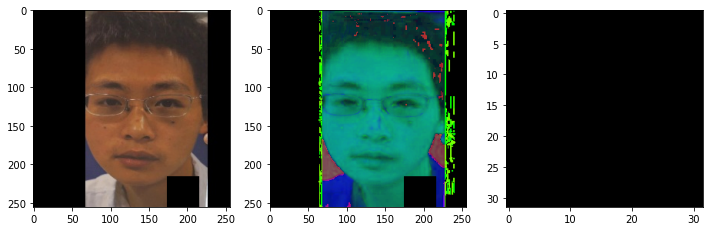

In [25]:
idx = random.randint(0, len(ds)-1)

_, map_x, label = ds[idx]
print(label)

fig, ax = plt.subplots(1,3, figsize = (12,12))
ax[0].imshow(_.permute(1,2,0).numpy()[:,:,:3])
ax[1].imshow(_.permute(1,2,0).numpy()[:,:,3:])
ax[2].imshow(map_x.numpy(), cmap= 'gray')
fig.show()

In [1]:
from src.model.CDCN import Classifier, FeatureExtractor, DepthEstor
from src.utils.layers import Conv2d
import torch

x = torch.rand(2,6,256,256)
featex = FeatureExtractor(6, Conv2d)
dep = DepthEstor(Conv2d)
cls = Classifier(2,Conv2d)


feat = featex(x)

print(feat.shape)
mp_pr = dep(feat)
print(mp_pr.shape)
cls_out = cls(feat)
print(cls_out.shape)


torch.Size([2, 384, 32, 32])
torch.Size([2, 32, 32])
torch.Size([2, 2])


In [6]:
str(type(cls.net[0])).strip("'>").split('.')[-1]

'Conv2d'

In [13]:
for k ,v in cls.state_dict().items():
    print(k)

net.0.weight
net.0.theta
net.0.center_mask
net.0.base_mask
net.0.learnable_mask
net.0.learnable_theta
net.1.weight
net.1.bias
net.1.running_mean
net.1.running_var
net.1.num_batches_tracked
net.4.weight
net.4.theta
net.4.center_mask
net.4.base_mask
net.4.learnable_mask
net.4.learnable_theta
net.5.weight
net.5.bias
net.5.running_mean
net.5.running_var
net.5.num_batches_tracked
arcspoof.weight


In [2]:
# from src.model.CDCN import FeatureExtractor
from src.model.ResNet18 import FeatureExtractor
import torch
from src.network import Model

from src.core.model_config import ModelConfig as model_cfg

# net = Model(model_cfg).cuda()

x = torch.rand(2,3,256,256)

# net = Model(model_cfg)
# out, mp, feat = net(x)
# len(feat.shape)

In [9]:
model = Model(model_cfg)

model.load_state_dict(torch.load('weight_acc\model_epoch=11000_test_acc=0.6781_best_k=1.pth', map_location= 'cpu')['model_checkpoint'])
model = model.cuda()
test_loader = InfiniteDataLoader(DataLoader(StandardDataset('data/train_img', get_patch= False), batch_size= 2, drop_last= True), 100)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/100 [00:00<?, ?it/s]

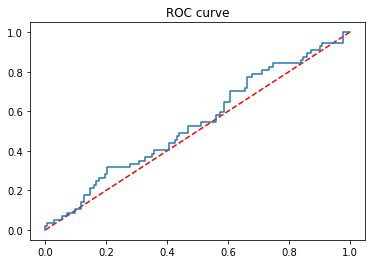

In [10]:
from src.core.tester import evaluate

evaluate(model, test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.model.CDCN import FeatureExtractor
from src.utils.loss import HardTripletLoss
# x = torch.rand(4,3,256,256).cuda()
# conv = FeatureExtractor().cuda()

# feat, map_x = conv(x)

# feat.shape

N = 20

pred = torch.rand(N, 512)

label = torch.randint(0, 2, (N,))


loss = HardTripletLoss(angular= True)

loss(pred, label)


tensor(0.0945)

In [ ]:
import torch
from src.utils.loss import KSubArcFace, MultiFocalLoss


arc = KSubArcFace(512, 2, 3)
loss = MultiFocalLoss(2, .5)

x= torch.rand(5,512)

label = torch.randint(0,2, (5,))

pred = arc(x, label)

loss(pred, label)

torch.Size([5])
torch.Size([5, 1])
torch.Size([5])


c:\Users\ADMIN\Desktop\20222\MetaFAS\src\utils\loss.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label)


tensor(4.5946, grad_fn=<MeanBackward0>)

In [3]:
from src.dataset import StandardDataset

import random
import matplotlib.pyplot as plt


ds = StandardDataset('data/train_img', get_patch= False)
ds1 = StandardDataset('data/train_img', get_patch= True)
ds2 = CombinedDataset(['data/train_img','data/test_img'], get_patch= False)

In [4]:
idx = random.randint(0, len(ds2)-1)

_, map_x, label = ds2[idx]
print(label)

fig, ax = plt.subplots(1,2, figsize = (12,12))

ax[0].imshow(_.permute(1,2,0).numpy())
ax[1].imshow(map_x.numpy(), cmap= 'gray')
fig.show()

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4988\1834815972.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


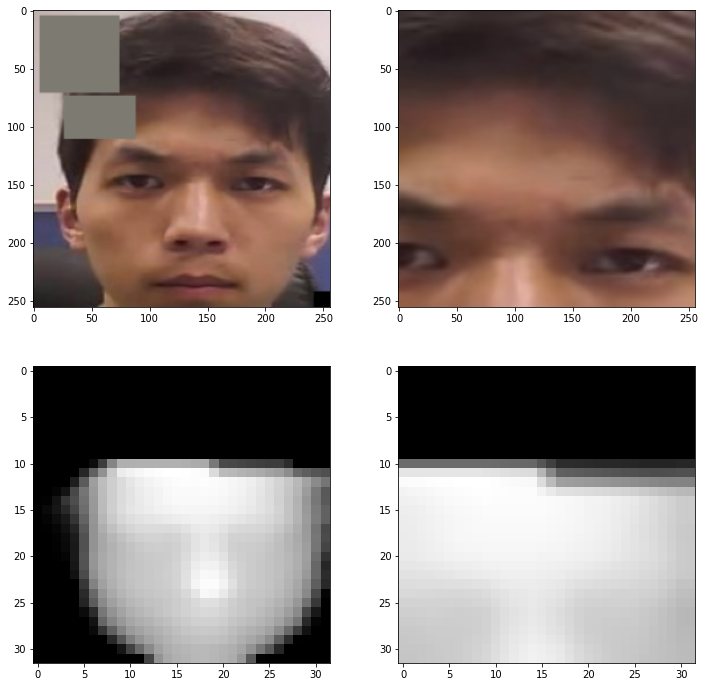

In [ ]:
idx = random.randint(0, len(ds1)-1)

rgb1, rgb2, dep1, dep2, label = ds1[idx]


fig, ax = plt.subplots(2,2, figsize = (12,12))

ax[0][0].imshow(rgb1.permute(1,2,0).numpy())
ax[0][1].imshow(rgb2.permute(1,2,0).numpy())
ax[1][0].imshow(dep1.numpy(), cmap= 'gray')
ax[1][1].imshow(dep2.numpy(), cmap= 'gray')
fig.show()

In [3]:
from src.network import Model
from src.core.model_config import ModelConfig as cfg
import torch
from src.utils.layers import LDConv2d


model = Model(cfg, LDConv2d)
std = torch.load('model_epoch=14800_test_acc=0.8821_best_k=2.pth', map_location= 'cpu')

model.load_state_dict(std['model_checkpoint'])
model = model.cuda()

In [ ]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Self-diagnosis script for TensorBoard.

Instructions: Save this script to your local machine, then execute it in
the same environment (virtualenv, Conda, etc.) from which you normally
run TensorBoard. Read the output and follow the directions.
"""


# This script may only depend on the Python standard library. It is not
# built with Bazel and should not assume any third-party dependencies.
import dataclasses
import errno
import functools
import hashlib
import inspect
import logging
import os
import pipes
import shlex
import socket
import subprocess
import sys
import tempfile
import textwrap
import traceback


# A *check* is a function (of no arguments) that performs a diagnostic,
# writes log messages, and optionally yields suggestions. Each check
# runs in isolation; exceptions will be caught and reported.
CHECKS = []


@dataclasses.dataclass(frozen=True)
class Suggestion:
    """A suggestion to the end user.

    Attributes:
      headline: A short description, like "Turn it off and on again". Should be
        imperative with no trailing punctuation. May contain inline Markdown.
      description: A full enumeration of the steps that the user should take to
        accept the suggestion. Within this string, prose should be formatted
        with `reflow`. May contain Markdown.
    """

    headline: str
    description: str


def check(fn):
    """Decorator to register a function as a check.

    Checks are run in the order in which they are registered.

    Args:
      fn: A function that takes no arguments and either returns `None` or
        returns a generator of `Suggestion`s. (The ability to return
        `None` is to work around the awkwardness of defining empty
        generator functions in Python.)

    Returns:
      A wrapped version of `fn` that returns a generator of `Suggestion`s.
    """

    @functools.wraps(fn)
    def wrapper():
        result = fn()
        return iter(()) if result is None else result

    CHECKS.append(wrapper)
    return wrapper


def reflow(paragraph):
    return textwrap.fill(textwrap.dedent(paragraph).strip())


def pip(args):
    """Invoke command-line Pip with the specified args.

    Returns:
      A bytestring containing the output of Pip.
    """
    # Suppress the Python 2.7 deprecation warning.
    PYTHONWARNINGS_KEY = "PYTHONWARNINGS"
    old_pythonwarnings = os.environ.get(PYTHONWARNINGS_KEY)
    new_pythonwarnings = "%s%s" % (
        "ignore:DEPRECATION",
        ",%s" % old_pythonwarnings if old_pythonwarnings else "",
    )
    command = [sys.executable, "-m", "pip", "--disable-pip-version-check"]
    command.extend(args)
    try:
        os.environ[PYTHONWARNINGS_KEY] = new_pythonwarnings
        return subprocess.check_output(command)
    finally:
        if old_pythonwarnings is None:
            del os.environ[PYTHONWARNINGS_KEY]
        else:
            os.environ[PYTHONWARNINGS_KEY] = old_pythonwarnings


def which(name):
    """Return the path to a binary, or `None` if it's not on the path.

    Returns:
      A bytestring.
    """
    binary = "where" if os.name == "nt" else "which"
    try:
        return subprocess.check_output([binary, name])
    except subprocess.CalledProcessError:
        return None


def sgetattr(attr, default):
    """Get an attribute off the `socket` module, or use a default."""
    sentinel = object()
    result = getattr(socket, attr, sentinel)
    if result is sentinel:
        print("socket.%s does not exist" % attr)
        return default
    else:
        print("socket.%s = %r" % (attr, result))
        return result


@check
def autoidentify():
    """Print the Git hash of this version of `diagnose_tensorboard.py`.

    Given this hash, use `git cat-file blob HASH` to recover the
    relevant version of the script.
    """
    module = sys.modules[__name__]
    try:
        source = inspect.getsource(module).encode("utf-8")
    except TypeError:
        logging.info("diagnose_tensorboard.py source unavailable")
    else:
        # Git inserts a length-prefix before hashing; cf. `git-hash-object`.
        blob = b"blob %d\0%s" % (len(source), source)
        hash = hashlib.sha1(blob).hexdigest()
        logging.info("diagnose_tensorboard.py version %s", hash)


@check
def general():
    logging.info("sys.version_info: %s", sys.version_info)
    logging.info("os.name: %s", os.name)
    na = type("N/A", (object,), {"__repr__": lambda self: "N/A"})
    logging.info(
        "os.uname(): %r",
        getattr(os, "uname", na)(),
    )
    logging.info(
        "sys.getwindowsversion(): %r",
        getattr(sys, "getwindowsversion", na)(),
    )


@check
def package_management():
    conda_meta = os.path.join(sys.prefix, "conda-meta")
    logging.info("has conda-meta: %s", os.path.exists(conda_meta))
    logging.info("$VIRTUAL_ENV: %r", os.environ.get("VIRTUAL_ENV"))


@check
def installed_packages():
    freeze = pip(["freeze", "--all"]).decode("utf-8").splitlines()
    packages = {line.split("==")[0]: line for line in freeze}
    packages_set = frozenset(packages)

    # For each of the following families, expect exactly one package to be
    # installed.
    expect_unique = [
        frozenset(
            [
                "tensorboard",
                "tb-nightly",
                "tensorflow-tensorboard",
            ]
        ),
        frozenset(
            [
                "tensorflow",
                "tensorflow-gpu",
                "tf-nightly",
                "tf-nightly-2.0-preview",
                "tf-nightly-gpu",
                "tf-nightly-gpu-2.0-preview",
            ]
        ),
        frozenset(
            [
                "tensorflow-estimator",
                "tensorflow-estimator-2.0-preview",
                "tf-estimator-nightly",
            ]
        ),
    ]
    salient_extras = frozenset(["tensorboard-data-server"])

    found_conflict = False
    for family in expect_unique:
        actual = family & packages_set
        for package in actual:
            logging.info("installed: %s", packages[package])
        if len(actual) == 0:
            logging.warning("no installation among: %s", sorted(family))
        elif len(actual) > 1:
            logging.warning("conflicting installations: %s", sorted(actual))
            found_conflict = True
    for package in sorted(salient_extras & packages_set):
        logging.info("installed: %s", packages[package])

    if found_conflict:
        preamble = reflow(
            """
            Conflicting package installations found. Depending on the order
            of installations and uninstallations, behavior may be undefined.
            Please uninstall ALL versions of TensorFlow and TensorBoard,
            then reinstall ONLY the desired version of TensorFlow, which
            will transitively pull in the proper version of TensorBoard. (If
            you use TensorBoard without TensorFlow, just reinstall the
            appropriate version of TensorBoard directly.)
            """
        )
        packages_to_uninstall = sorted(
            frozenset().union(*expect_unique) & packages_set
        )
        commands = [
            "pip uninstall %s" % " ".join(packages_to_uninstall),
            "pip install tensorflow  # or `tensorflow-gpu`, or `tf-nightly`, ...",
        ]
        message = "%s\n\nNamely:\n\n%s" % (
            preamble,
            "\n".join("\t%s" % c for c in commands),
        )
        yield Suggestion("Fix conflicting installations", message)


@check
def tensorboard_python_version():
    from tensorboard import version

    logging.info("tensorboard.version.VERSION: %r", version.VERSION)


@check
def tensorflow_python_version():
    import tensorflow as tf

    logging.info("tensorflow.__version__: %r", tf.__version__)
    logging.info("tensorflow.__git_version__: %r", tf.__git_version__)


@check
def tensorboard_data_server_version():
    try:
        import tensorboard_data_server
    except ImportError:
        logging.info("no data server installed")
        return

    path = tensorboard_data_server.server_binary()
    logging.info("data server binary: %r", path)
    if path is None:
        return

    try:
        subprocess_output = subprocess.run(
            [path, "--version"],
            capture_output=True,
            check=True,
        )
    except subprocess.CalledProcessError as e:
        logging.info("failed to check binary version: %s", e)
    else:
        logging.info(
            "data server binary version: %s", subprocess_output.stdout.strip()
        )


@check
def tensorboard_binary_path():
    logging.info("which tensorboard: %r", which("tensorboard"))


@check
def addrinfos():
    sgetattr("has_ipv6", None)
    family = sgetattr("AF_UNSPEC", 0)
    socktype = sgetattr("SOCK_STREAM", 0)
    protocol = 0
    flags_loopback = sgetattr("AI_ADDRCONFIG", 0)
    flags_wildcard = sgetattr("AI_PASSIVE", 0)

    hints_loopback = (family, socktype, protocol, flags_loopback)
    infos_loopback = socket.getaddrinfo(None, 0, *hints_loopback)
    print("Loopback flags: %r" % (flags_loopback,))
    print("Loopback infos: %r" % (infos_loopback,))

    hints_wildcard = (family, socktype, protocol, flags_wildcard)
    infos_wildcard = socket.getaddrinfo(None, 0, *hints_wildcard)
    print("Wildcard flags: %r" % (flags_wildcard,))
    print("Wildcard infos: %r" % (infos_wildcard,))


@check
def readable_fqdn():
    # May raise `UnicodeDecodeError` for non-ASCII hostnames:
    # https://github.com/tensorflow/tensorboard/issues/682
    try:
        logging.info("socket.getfqdn(): %r", socket.getfqdn())
    except UnicodeDecodeError as e:
        try:
            binary_hostname = subprocess.check_output(["hostname"]).strip()
        except subprocess.CalledProcessError:
            binary_hostname = b"<unavailable>"
        is_non_ascii = not all(
            0x20
            <= (ord(c) if not isinstance(c, int) else c)
            <= 0x7E  # Python 2
            for c in binary_hostname
        )
        if is_non_ascii:
            message = reflow(
                """
                Your computer's hostname, %r, contains bytes outside of the
                printable ASCII range. Some versions of Python have trouble
                working with such names (https://bugs.python.org/issue26227).
                Consider changing to a hostname that only contains printable
                ASCII bytes.
                """
                % (binary_hostname,)
            )
            yield Suggestion("Use an ASCII hostname", message)
        else:
            message = reflow(
                """
                Python can't read your computer's hostname, %r. This can occur
                if the hostname contains non-ASCII bytes
                (https://bugs.python.org/issue26227). Consider changing your
                hostname, rebooting your machine, and rerunning this diagnosis
                script to see if the problem is resolved.
                """
                % (binary_hostname,)
            )
            yield Suggestion("Use a simpler hostname", message)
        raise e


@check
def stat_tensorboardinfo():
    # We don't use `manager._get_info_dir`, because (a) that requires
    # TensorBoard, and (b) that creates the directory if it doesn't exist.
    path = os.path.join(tempfile.gettempdir(), ".tensorboard-info")
    logging.info("directory: %s", path)
    try:
        stat_result = os.stat(path)
    except OSError as e:
        if e.errno == errno.ENOENT:
            # No problem; this is just fine.
            logging.info(".tensorboard-info directory does not exist")
            return
        else:
            raise
    logging.info("os.stat(...): %r", stat_result)
    logging.info("mode: 0o%o", stat_result.st_mode)
    if stat_result.st_mode & 0o777 != 0o777:
        preamble = reflow(
            """
            The ".tensorboard-info" directory was created by an old version
            of TensorBoard, and its permissions are not set correctly; see
            issue #2010. Change that directory to be world-accessible (may
            require superuser privilege):
            """
        )
        # This error should only appear on Unices, so it's okay to use
        # Unix-specific utilities and shell syntax.
        quote = getattr(shlex, "quote", None) or pipes.quote  # Python <3.3
        command = "chmod 777 %s" % quote(path)
        message = "%s\n\n\t%s" % (preamble, command)
        yield Suggestion('Fix permissions on "%s"' % path, message)


@check
def source_trees_without_genfiles():
    roots = list(sys.path)
    if "" not in roots:
        # Catch problems that would occur in a Python interactive shell
        # (where `""` is prepended to `sys.path`) but not when
        # `diagnose_tensorboard.py` is run as a standalone script.
        roots.insert(0, "")

    def has_tensorboard(root):
        return os.path.isfile(os.path.join(root, "tensorboard", "__init__.py"))

    def has_genfiles(root):
        sample_genfile = os.path.join("compat", "proto", "summary_pb2.py")
        return os.path.isfile(os.path.join(root, "tensorboard", sample_genfile))

    def is_bad(root):
        return has_tensorboard(root) and not has_genfiles(root)

    tensorboard_roots = [root for root in roots if has_tensorboard(root)]
    bad_roots = [root for root in roots if is_bad(root)]

    logging.info(
        "tensorboard_roots (%d): %r; bad_roots (%d): %r",
        len(tensorboard_roots),
        tensorboard_roots,
        len(bad_roots),
        bad_roots,
    )

    if bad_roots:
        if bad_roots == [""]:
            message = reflow(
                """
                Your current directory contains a `tensorboard` Python package
                that does not include generated files. This can happen if your
                current directory includes the TensorBoard source tree (e.g.,
                you are in the TensorBoard Git repository). Consider changing
                to a different directory.
                """
            )
        else:
            preamble = reflow(
                """
                Your Python path contains a `tensorboard` package that does
                not include generated files. This can happen if your current
                directory includes the TensorBoard source tree (e.g., you are
                in the TensorBoard Git repository). The following directories
                from your Python path may be problematic:
                """
            )
            roots = []
            realpaths_seen = set()
            for root in bad_roots:
                label = repr(root) if root else "current directory"
                realpath = os.path.realpath(root)
                if realpath in realpaths_seen:
                    # virtualenvs on Ubuntu install to both `lib` and `local/lib`;
                    # explicitly call out such duplicates to avoid confusion.
                    label += " (duplicate underlying directory)"
                realpaths_seen.add(realpath)
                roots.append(label)
            message = "%s\n\n%s" % (
                preamble,
                "\n".join("  - %s" % s for s in roots),
            )
        yield Suggestion(
            "Avoid `tensorboard` packages without genfiles", message
        )


# Prefer to include this check last, as its output is long.
@check
def full_pip_freeze():
    logging.info(
        "pip freeze --all:\n%s", pip(["freeze", "--all"]).decode("utf-8")
    )


def set_up_logging():
    # Manually install handlers to prevent TensorFlow from stomping the
    # default configuration if it's imported:
    # https://github.com/tensorflow/tensorflow/issues/28147
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler(sys.stdout)
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)


def main():
    set_up_logging()

    print("### Diagnostics")
    print()

    print("<details>")
    print("<summary>Diagnostics output</summary>")
    print()

    markdown_code_fence = "``````"  # seems likely to be sufficient
    print(markdown_code_fence)
    suggestions = []
    for (i, check) in enumerate(CHECKS):
        if i > 0:
            print()
        print("--- check: %s" % check.__name__)
        try:
            suggestions.extend(check())
        except Exception:
            traceback.print_exc(file=sys.stdout)
            pass
    print(markdown_code_fence)
    print()
    print("</details>")

    for suggestion in suggestions:
        print()
        print("### Suggestion: %s" % suggestion.headline)
        print()
        print(suggestion.description)

    print()
    print("### Next steps")
    print()
    if suggestions:
        print(
            reflow(
                """
                Please try each suggestion enumerated above to determine whether
                it solves your problem. If none of these suggestions works,
                please copy ALL of the above output, including the lines
                containing only backticks, into your GitHub issue or comment. Be
                sure to redact any sensitive information.
                """
            )
        )
    else:
        print(
            reflow(
                """
                No action items identified. Please copy ALL of the above output,
                including the lines containing only backticks, into your GitHub
                issue or comment. Be sure to redact any sensitive information.
                """
            )
        )


if __name__ == "__main__":
    main()